In [1]:
!pip install fitparse

In [2]:
!git clone https://gist.github.com/kmader/da7c7ef23f53b7e9e1e672d189afee02

fatal: destination path 'da7c7ef23f53b7e9e1e672d189afee02' already exists and is not an empty directory.


In [0]:
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fitparse
plt.style.use('ggplot')

In [4]:
fit_files = list(Path('.').glob('*/*.fit'))
fit_files

[PosixPath('da7c7ef23f53b7e9e1e672d189afee02/garmin.fit'),
 PosixPath('da7c7ef23f53b7e9e1e672d189afee02/wahoo.fit')]

In [0]:
def parse_fit(in_path):
  fit_data = fitparse.FitFile(str(in_path))
  fit_df = pd.DataFrame([
      {k['name']: k['value']
       for k in a.as_dict()['fields']} 
      for a in fit_data.get_messages('record')])
  fit_df['elapsed_time'] = (fit_df['timestamp']-fit_df['timestamp'].min()).dt.total_seconds()
  return fit_df

In [6]:
both_fit_df = pd.concat([parse_fit(c_file).assign(device=c_file.stem) 
           for c_file in fit_files]).reset_index()
both_fit_df.describe().T.query('count>4000')

count          mean            std          min  \
index              6583.0  1.645267e+03     950.275348          0.0   
altitude           6348.0  4.344762e+02      26.444938        403.2   
cadence            6583.0  7.960398e+01      11.938950          0.0   
distance           6582.0  5.039808e+03    3015.163122          0.0   
elapsed_time       6583.0  1.645267e+03     950.275348          0.0   
enhanced_altitude  6348.0  4.344762e+02      26.444938        403.2   
enhanced_speed     6582.0  2.786078e+00       0.797892          0.0   
heart_rate         6583.0  1.469424e+02      15.640800         57.0   
position_lat       6458.0  5.653898e+08   67669.839447  565274178.0   
position_long      6458.0  1.016611e+08  179685.124652  101321891.0   
speed              6582.0  2.786078e+00       0.797892          0.0   

                            25%           50%           75%           max  
index              8.225000e+02  1.645000e+03  2.468000e+03  3.301000e+03  
altitude           4.086000e+02  4.152000e+02  4.608000e+02  4.684000e+02  
cadence            8.000000e+01  8.200000e+01  8.500000e+01  1.140000e+02  
distance           2.296352e+03  5.082555e+03  7.688613e+03  9.921690e+03  
elapsed_time       8.225000e+02  1.645000e+03  2.468000e+03  3.301000e+03  
enhanced_altitude  4.086000e+02  4.152000e+02  4.608000e+02  4.684000e+02  
enhanced_speed     2.323000e+00  2.858500e+00  3.331000e+00  1.340800e+01  
heart_rate         1.330000e+02  1.520000e+02  1.590000e+02  1.750000e+02  
position_lat       5.653227e+08  5.654013e+08  5.654451e+08  5.655004e+08  
position_long      1.014933e+08  1.017024e+08  1.018297e+08  1.018898e+08  
speed              2.323000e+00  2.858500e+00  3.331000e+00  1.340800e+01

(120, 200)

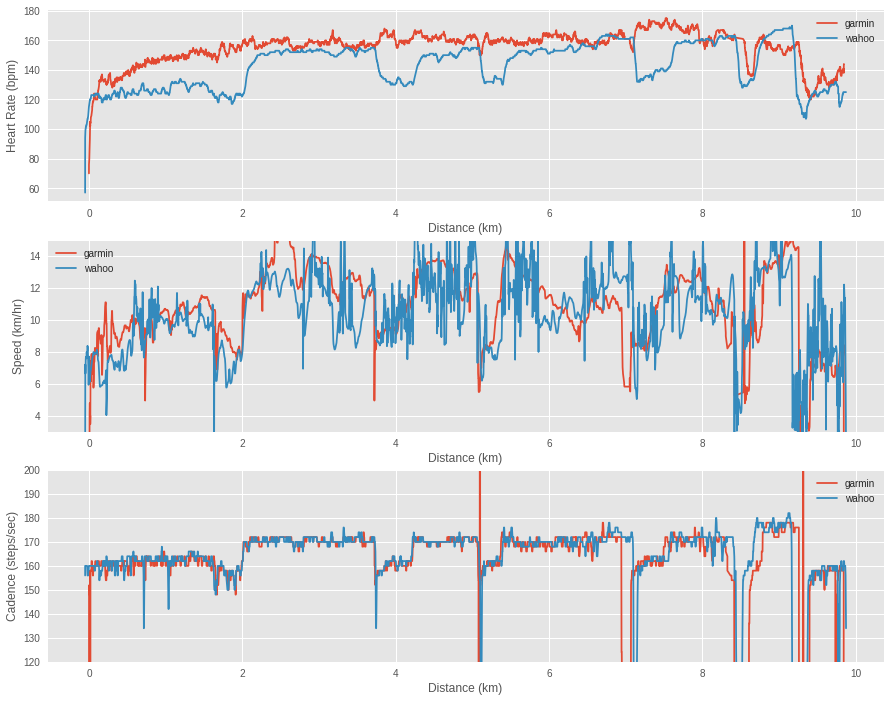

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
for c_grp, c_rows in both_fit_df.groupby('device'):
  c_rows = c_rows.copy()
  if c_grp=='wahoo':
    c_rows['distance']-=50
  ax1.plot(c_rows['distance']/1e3, c_rows['heart_rate'], label=c_grp)
  ax2.plot(c_rows['distance']/1e3, c_rows['speed']/1000*3600, label=c_grp)
  ax3.plot(c_rows['distance']/1e3, 2*c_rows['cadence'], label=c_grp)
ax1.legend()

ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Heart Rate (bpm)')

ax2.legend()
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Speed (km/hr)')
ax2.set_ylim(3, 15)

ax3.legend()
ax3.set_xlabel('Distance (km)')
ax3.set_ylabel('Cadence (steps/sec)')
ax3.set_ylim(120, 200)

In [0]:
both_fit_df['dist_cat_km'] = both_fit_df.apply(lambda x: x['distance'] +
                                            (-75 if x['device']=='wahoo' else 0), 1).map(lambda x: (x//10)/100)
vs_df = both_fit_df.pivot_table(values=['heart_rate', 'speed', 'cadence'], 
                        index='dist_cat_km', 
                       columns='device').dropna()

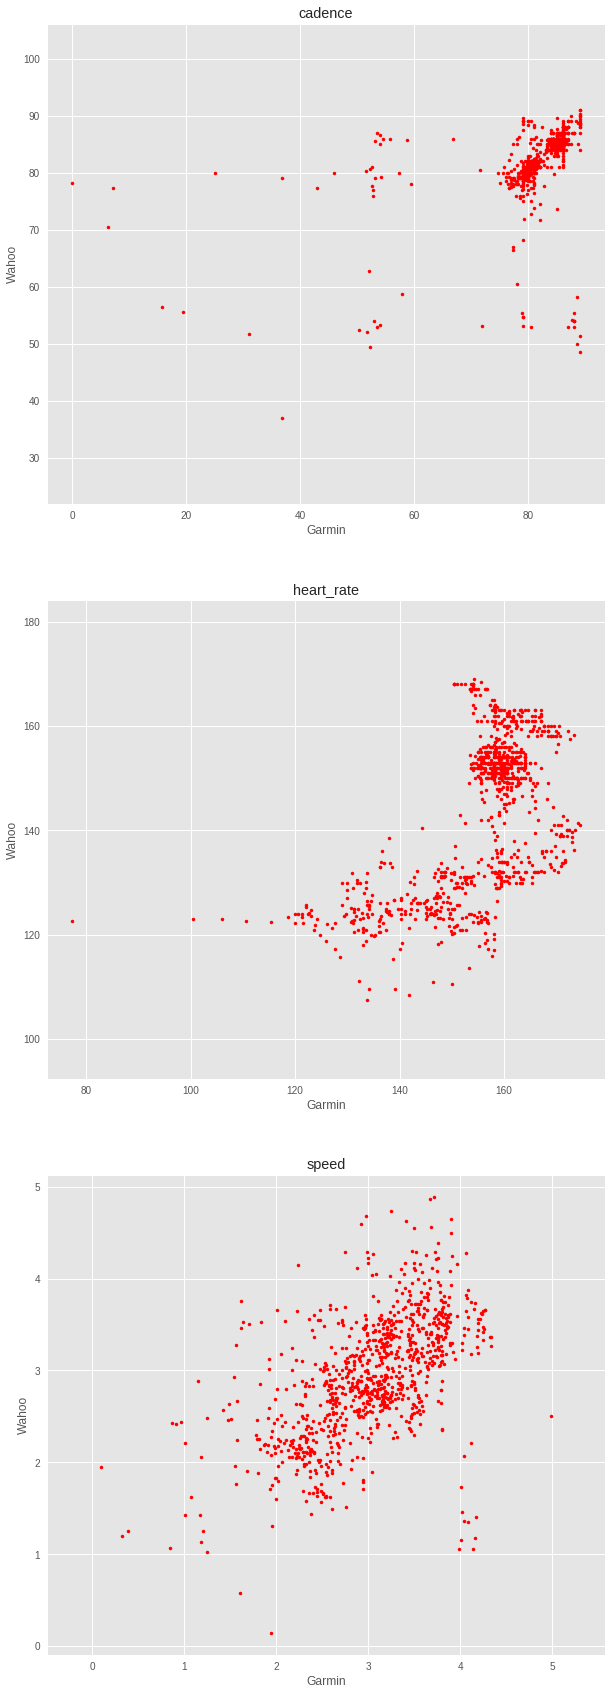

In [9]:
met_names = vs_df.columns.levels[0].tolist()
fig, m_axs = plt.subplots(len(met_names), 1, figsize=(10, 30))
for c_ax, c_met in zip(m_axs, met_names):
  c_ax.plot(vs_df[c_met]['garmin'], vs_df[c_met]['wahoo'], 'r.')
  c_ax.axis('equal')
  c_ax.set_title(c_met)
  c_ax.set_xlabel('Garmin')
  c_ax.set_ylabel('Wahoo')